# Errro Testing

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colormaps
from numpy.random import random
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from lib.Model import *

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
    "lines.linewidth": 1,
    "lines.markersize": 3
})

Model = lambda t, params, m, xi, vi:Analytical_Model(t, k=params, m=m, x1_i=xi[0], x2_i=xi[1], v1_i=vi[0], v2_i=vi[1])

## Mean Square Error
define the mean square error (MSE) to be
$$
E_{\rm MSE}\left(\vec{k}\right) = \frac{1}{N}\sum_{i=1}^{2}\sum_{j=0}^{N-1}\left(x_{i,j}-x_{\rm theory,j}\left(\vec{k}\right)\right)^2,
$$
where the experimental position data points are given by
$$
x_{i,j},\quad j=0,1,\ldots, N-1,
$$
where $i=1,2$ denote the two masses position, and $\vec{k}=\left(k_1,k_2,k_3\right)$ denote the spring constant.

Define the probability to be
$$
P\left(\vec{k}\right) = \exp\left(-E_{\rm MSE}\left(\vec{k}\right)^2\right)
$$

## First testing
- fix for $k_1$ and $k_3$ to be $100$
- using $k_2 = 10$ to be the target spring constant

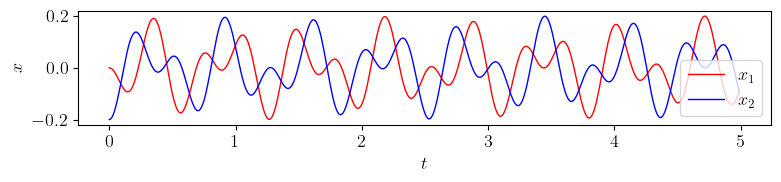

In [431]:
t = np.arange(0,5,0.01)
k = (100,100,100)
m = (1.0, 1.0)
xi = (0.0, -0.2)
vi = (0, 0)
(x1_data, x2_data, v1_data, v2_data) = Model(t, k, m, xi, vi)

fig = plt.figure(figsize=(8,2),dpi=100)
plt.plot(t,x1_data, color="red", label=r"$x_1$")
plt.plot(t,x2_data, color="blue", label=r"$x_2$")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.tight_layout()
plt.show()

## Mean Square Error

In [497]:
def MSE(t, k, x1_data, x2_data, m, xi, vi):
    N = len(t)
    x1_theo, x2_theo, v1_theo ,v2_theo = Model(t, k, m, xi, vi)
    MSE1 = np.sum((x1_data - x1_theo)**2) / N
    MSE2 = np.sum((x2_data - x2_theo)**2) / N
    return MSE1+MSE2

def P_MSE(t, k, x1_data, x2_data, m, xi, vi):
    N = len(t)
    x1_theo, x2_theo, v1_theo ,v2_theo = Model(t, k, m, xi, vi)
    MSE1 = np.sum((x1_data - x1_theo)**2) / N
    MSE2 = np.sum((x2_data - x2_theo)**2) / N
    P = np.exp(-(MSE1+MSE2))
    return P**500

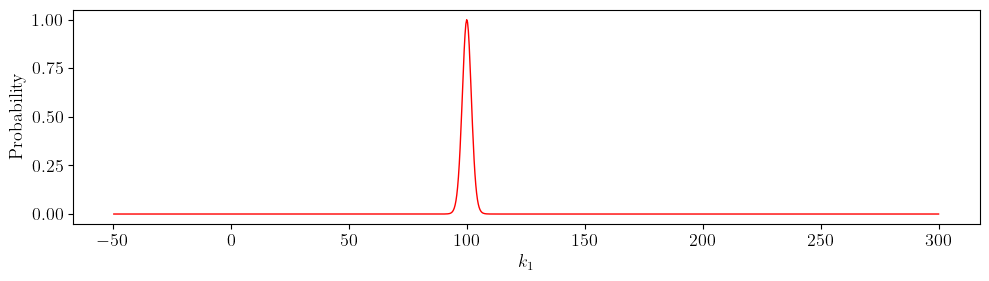

In [499]:
k2 = np.linspace(-50,3*k[1],1000)
Prob = np.zeros(len(k2))
for i in range(len(k2)):
    params = (k[0], k2[i], k[2])
    Prob[i] = P_MSE(t, params, x1_data, x2_data, m, xi, vi)

    
fig = plt.figure(figsize=(10,3), dpi=100)
plt.plot(k2,Prob, color="red")
plt.xlabel("$k_1$")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

In [453]:
fig.savefig("../MCMC-note/fig/Prob2.pdf" , pad_inches=0.1)

In [538]:
N = 10000

k2 = 200*random()
K2 = np.zeros(N)
delta = 10
accN = 0

for i in range(1000):
    k2_ = k2 + delta * (2*random()-1)
    p  = P_MSE(t, (k[0], k2,  k[2]), x1_data, x2_data, m, xi, vi)
    p_ = P_MSE(t, (k[0], k2_, k[2]), x1_data, x2_data, m, xi, vi)
    if(p_ >= p or random() < p_/p): k2 = k2_
for i in range(N):
    k2_ = k2 + delta * (2*random()-1)
    p  = P_MSE(t, (k[0], k2,  k[2]), x1_data, x2_data, m, xi, vi)
    p_ = P_MSE(t, (k[0], k2_, k[2]), x1_data, x2_data, m, xi, vi)
    if(p_ >= p or random() < p_/p):
        k2 = k2_
        accN += 1
    K2[i] = k2
acc_rate = accN/N
print("rate : %.5f"%acc_rate)

rate : 0.30980


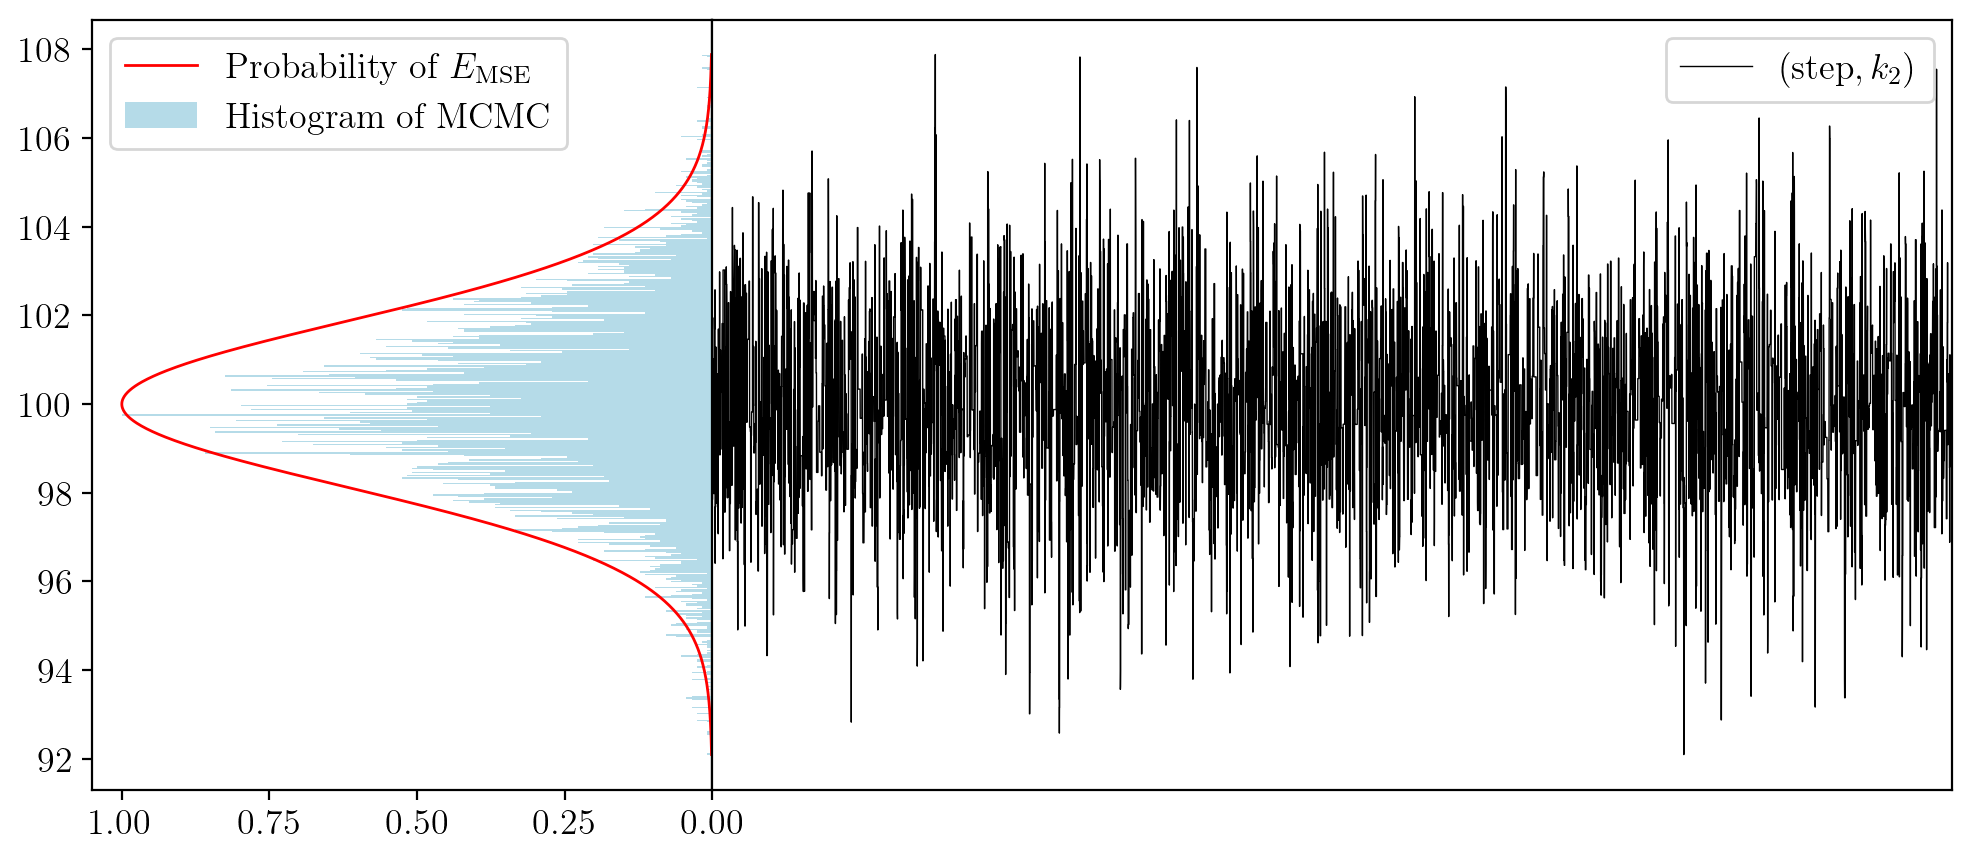

In [539]:
fig = plt.figure(figsize=(12,5), dpi=200)
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)

k2 = np.linspace(K2.min(),K2.max(),1000)
Prob = np.zeros(len(k2))
for i in range(len(k2)):
    params = (k[0], k2[i], k[2])
    Prob[i] = P_MSE(t, params, x1_data, x2_data, m, xi, vi)

ax1.plot(Prob, k2, color="red",linewidth=1, zorder=25,
         label=r"Probability of $E_{\rm MSE}$")

# max_index, _ = find_peaks(Prob)
# for k2_localmax in k2[max_index]:
#     ax1.hlines(y=k2_localmax, xmin=0, xmax=1,       color="black", alpha=0.2, zorder=1, linewidth=0.5)
#     ax2.hlines(y=k2_localmax, xmin=0, xmax=K2.size, color="black", alpha=0.2, zorder=1, linewidth=0.5)

counts, bins = np.histogram(K2, bins=int(N/20))
ax1.hist(bins[:-1], bins, color="lightblue",
         weights=counts/counts.max(), zorder=20,
         orientation='horizontal', alpha=0.9,
         label=r"Histogram of MCMC")

ax2.plot(K2,color="k", linewidth=0.5,
        label=r"$\left({\rm step}, k_2\right)$")

ax1.invert_xaxis()
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_xlim(0,K2.size)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.subplots_adjust(wspace=0)
plt.show()

In [540]:
fig.savefig("../MCMC-note/fig/MCMC-acc%.5f.pdf"%acc_rate , pad_inches=0.0)